In [47]:
import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt
from libpysal.weights import Queen
from esda.moran import Moran
from pysal.model import spreg
import numpy as np

In [48]:
# 1. Load and Visualize the Dataset

shapefile_path = "States_shapefile.shp"
shapefile = gpd.read_file(shapefile_path)

# Load the associated .dbf file
dbf_path = "States_shapefile.dbf"
dbf_data = gpd.read_file(dbf_path)

                Location Median_Annual_Household_Income
0          United States                        $69,717
1                Alabama                        $53,913
2                 Alaska                        $77,845
3                Arizona                        $69,056
4               Arkansas                        $52,528
5             California                        $84,907
6               Colorado                        $82,254
7            Connecticut                        $83,771
8               Delaware                        $71,091
9   District of Columbia                        $90,088
10               Florida                        $63,062
11               Georgia                        $66,559
12                Hawaii                        $84,857
13                 Idaho                        $66,474
14              Illinois                        $72,205
15               Indiana                        $62,743
16                  Iowa                        

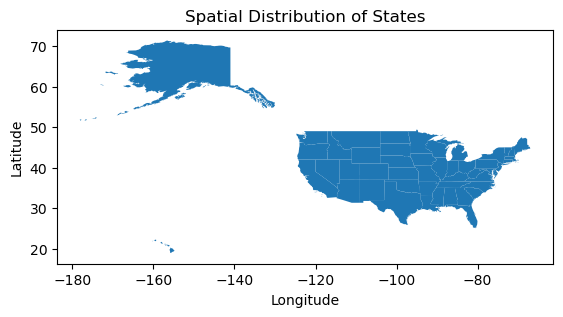

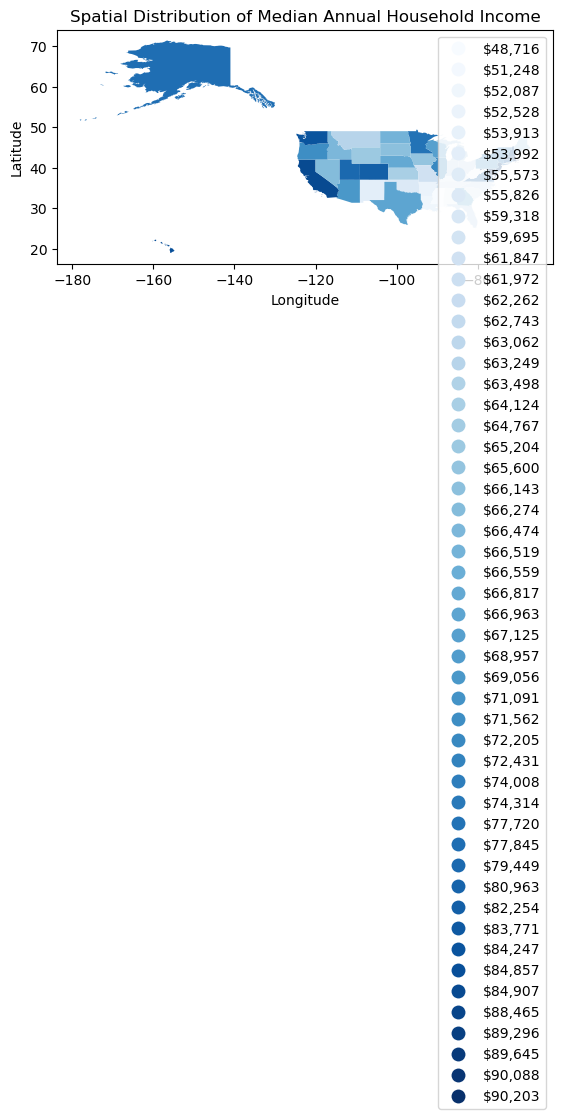

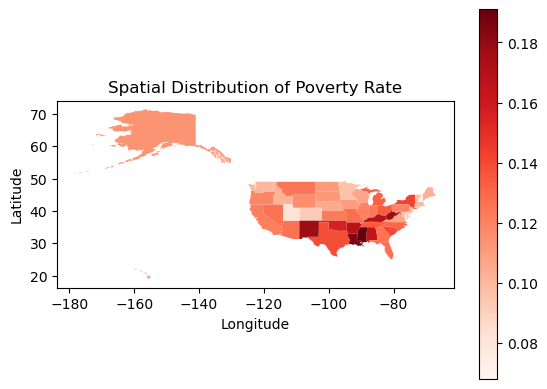

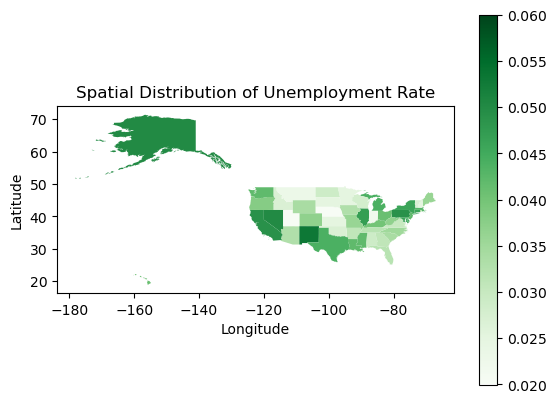

In [49]:

# Load socio-economic data from CSV files
income_df = pd.read_csv("income.csv", header=None, names=["Location", "Median_Annual_Household_Income"])
poverty_df = pd.read_csv("poverty.csv", header=None, names=["Location", "Poverty_Rate"])
unemployment_df = pd.read_csv("unemp.csv", header=None, names=["Location", "Unemployment_Rate"])
print(income_df)

shapefile['State_Name_Lower'] = shapefile['State_Name'].str.lower()
income_df['Location_Lower'] = income_df['Location'].str.lower()
poverty_df['Location_Lower'] = poverty_df['Location'].str.lower()
unemployment_df['Location_Lower'] = unemployment_df['Location'].str.lower()

# Merge shapefile with socio-economic data

merged_data = shapefile.merge(income_df, how='left', left_on='State_Name_Lower', right_on='Location_Lower')
merged_data = merged_data.merge(poverty_df, how='left', left_on='State_Name_Lower', right_on='Location_Lower')
merged_data = merged_data.merge(unemployment_df, how='left', left_on='State_Name_Lower', right_on='Location_Lower')


# Spatial plot


shapefile.plot()
plt.title('Spatial Distribution of States')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.show()



# Income plot

merged_data.plot(column='Median_Annual_Household_Income', cmap='Blues', legend=True)

plt.title('Spatial Distribution of Median Annual Household Income')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.show()


# Poverty plot

merged_data.plot(column='Poverty_Rate', cmap='Reds', legend=True)

plt.title('Spatial Distribution of Poverty Rate')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.show()


# Unemployment plot


merged_data.plot(column='Unemployment_Rate', cmap='Greens', legend=True)

plt.title('Spatial Distribution of Unemployment Rate')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.show()




In [40]:
# 2. Spatial weights matrix

from libpysal.weights import Queen
merged_data_filtered = merged_data[merged_data['State_Name_Lower'] != 'alaska']
merged_data_filtered = merged_data_filtered[merged_data_filtered['State_Name_Lower'] != 'hawaii']

# Create spatial weights matrix using Queen contiguity
w = Queen.from_dataframe(merged_data_filtered, use_index=False)
 
# Print the spatial weights matrix
print(w)

In [41]:
# 3. Spatial Autocorrelation 
from esda.moran import Moran

# Calculate Moran's I for a socio-economic indicator (e.g., income levels)
merged_data_filtered['Median_Annual_Household_Income'] = merged_data_filtered['Median_Annual_Household_Income'].astype(str)
merged_data_filtered['Median_Annual_Household_Income'] = pd.to_numeric(merged_data_filtered['Median_Annual_Household_Income'].str.replace('$', '').str.replace(',', ''), errors='coerce')

# Drop rows with NaN values (if any)
merged_data_filtered.dropna(subset=['Median_Annual_Household_Income'], inplace=True)

# Extract the numeric values from the column
y = merged_data_filtered['Median_Annual_Household_Income']

# Calculate Moran's I
moran = Moran(y, w)

# Print Moran's I statistic
print("Moran's I:", moran.I)


Moran's I: 0.38334230952065385


/var/folders/mw/2csswy5j1qn9lgh_0h301f3h0000gn/T/ipykernel_47030/4171518191.py:6: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  merged_data_filtered['Median_Annual_Household_Income'] = pd.to_numeric(merged_data_filtered['Median_Annual_Household_Income'].str.replace('$', '').str.replace(',', ''), errors='coerce')


In [43]:
# 4. Spatial Regression


# Prepare data
y = np.array(merged_data_filtered['Median_Annual_Household_Income'])
X = np.array(merged_data_filtered[['Poverty_Rate', 'Unemployment_Rate']])  

# Create spatial weights matrix
w = Queen.from_dataframe(merged_data_filtered)

# Run Spatial Lag Model
model = spreg.ML_Lag(y, X, w=w, name_y='Median_Annual_Household_Income', name_x=['Poverty_Rate', 'Unemployment_Rate']) 
print(model.summary)



REGRESSION RESULTS
------------------

SUMMARY OF OUTPUT: MAXIMUM LIKELIHOOD SPATIAL LAG (METHOD = FULL)
-----------------------------------------------------------------
Data set            :     unknown
Weights matrix      :     unknown
Dependent Variable  :Median_Annual_Household_Income                Number of Observations:          49
Mean dependent var  :  68749.5918                Number of Variables   :           4
S.D. dependent var  :  11246.3765                Degrees of Freedom    :          45
Pseudo R-squared    :      0.7535
Spatial Pseudo R-squared:  0.7536
Log likelihood      :   -491.7743
Sigma-square ML     :30539031.3049                Akaike info criterion :     991.549
S.E of regression   :   5526.2131                Schwarz criterion     :     999.116

------------------------------------------------------------------------------------
            Variable     Coefficient       Std.Error     z-Statistic     Probability
--------------------------------------------

/var/folders/mw/2csswy5j1qn9lgh_0h301f3h0000gn/T/ipykernel_47030/2336288831.py:9: FutureWarning: `use_index` defaults to False but will default to True in future. Set True/False directly to control this behavior and silence this warning
  w = Queen.from_dataframe(merged_data_filtered)


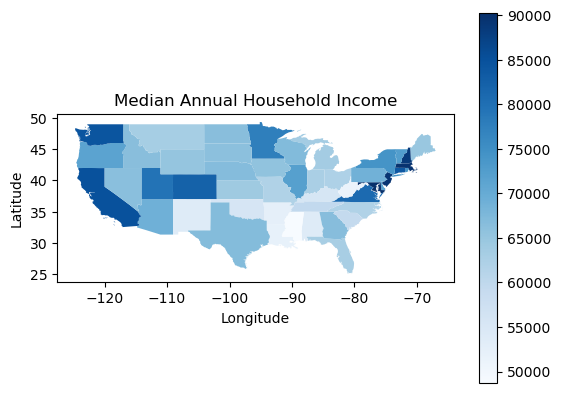

In [46]:
# 5. Visualization

# Plot choropleth map
merged_data_filtered.plot(column='Median_Annual_Household_Income', cmap='Blues', legend=True)
plt.title('Median Annual Household Income')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.show()